In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [6]:
class setup:
    div2V = 1500 / 100 # В/дел., 1.5кВ на 100 делений
    L = 0.75 # м, Расстояние от центра кристалла до экрана
    wavelen = 0.63e-6 # м, длина волны
    n0 = 2.29 # коэффициент преломления обыкновенной волны
    l = 26e-3 # мм, длина кристалла

    r_err = 0.1 # cm

In [7]:
data = mipt.read_excel('data/472.xlsx', usecols=['A', 'B', 'C', 'D']).dropna(how='all')
data

,m,r1,r2,r3
0,0.0,0.00,0.00,0.0
1,1.0,2.45,2.50,2.6
2,2.0,3.50,3.50,3.6
3,3.0,4.25,4.30,4.4
4,4.0,4.90,4.95,5.1
5,5.0,5.50,5.55,5.7
6,6.0,6.05,NaN,6.2
7,7.0,NaN,NaN,6.7
8,8.0,NaN,NaN,7.1
9,NaN,NaN,NaN,7.6


n - n_0 = 0.112 \pm 0.004
n - n_0 = 0.118 \pm 0.005
n - n_0 = 0.116 \pm 0.005
result: n - n_0 = 0.115 \pm 0.005


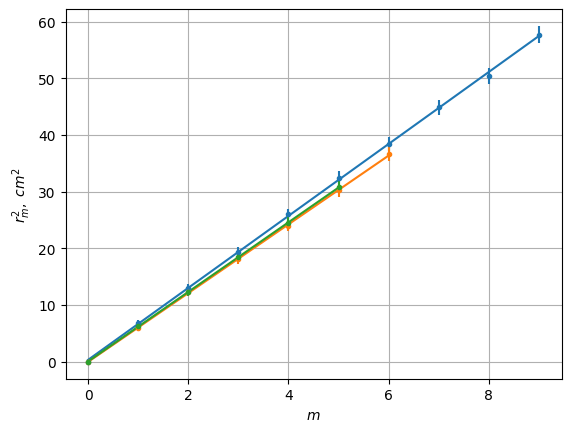

In [8]:
def interp_linear(x, y):
    coeffs = np.polyfit(x, y, 1)
    return lambda x: coeffs[0] * x + coeffs[1]


clean = (data['r1'] + data['r2']) / 2 # в см !!!

def plot(r):
    r = r.dropna()
    r2 = r**2

    m = np.array(range(0, len(r2)))

    # Погрешность порядка определения центра
    line = interp_linear(m, r2)
    x, y, interp = mipt.plot(m, r2, yerr = 2 * r * setup.r_err)

    mnk_dat = mipt.mnk(x, y)

    tangent = mnk_dat.data['a']
    tangent_err = mnk_dat.data['da']

    delta_n = (setup.wavelen / setup.l * (setup.n0 * setup.L)**2 / tangent)[0] * 1e4
    # Погрешность длины + остальное по мелочи
    ddelta_n = delta_n * np.linalg.norm([3e-2 / setup.L])

    print('n - n_0 = {:.3} \pm {:.1}'.format(delta_n, ddelta_n))

    return delta_n, ddelta_n

d3, dd3 = plot(data['r3'])
d1, dd1 = plot(data['r1'])
d2, dd2 = plot(data['r2'])

print('result: n - n_0 = {:.3} \pm {:.1}'.format(np.mean([d1, d2, d3]), np.mean([dd1, dd2, dd3])))

plt.grid(True)
plt.xlabel(r"$m$")
plt.ylabel(r"$r_m^2, \; cm^2$")
plt.savefig('gen/r2m.pdf')
